In [39]:
from __future__ import division, print_function, unicode_literals
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### First sight into data

In [5]:
train_data = pd.read_csv("../data/titanic/train.csv")
test_data = pd.read_csv("../data/titanic/test.csv")

In [6]:
print train_data.shape
print test_data.shape

(891, 12)
(418, 11)


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [8]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### First sight about Features
**Useless**
1. Name
2. Ticket
3. Cabin
4. PassengerId

**Target**
Survived


In [9]:
target_column = 'Survived'
useless_column_list = ['Survived', 'Name', 'Ticket', 'Cabin',
                      'PassengerId']
useless_column_test_list = ['Name', 'Ticket', 'Cabin',
                      'PassengerId']
y_train = train_data['Survived']
X_train = train_data.drop(useless_column_list, axis=1)
X_test = test_data.drop(useless_column_test_list, axis=1)

#### Not Skewed data

In [10]:
y_train.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [11]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


#### Numeric or Scattered
Numeric: Age, SibSp, Parch and Fare

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Pclass      891 non-null int64
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 48.8+ KB


#### Missing Value：Age or Embarked
Age: Average
Embarked: Most Frequent

In [13]:
X_train['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [14]:
X_train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

1. Build a Base System

#### Prepared Data
Filling in missing value

In [15]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from collections import Counter


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, selector):
        self._selector = selector
        return
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self._selector].values
    

class CategoricalImputer(TransformerMixin):
    def __init__(self):
        self.fill = {}
        return
    
    def fit(self, X, y=None):
        '''
        find the most frequent imputer in every column
        '''
        m, n = X.shape
        for col in xrange(n):
            col_data = X[:, col]
            cnt = Counter(col_data)
            self.fill[col] = cnt.most_common(1)[0][0]
            
        return self
    
    def transform(self, X, y=None):
        m, n = X.shape
        for col in xrange(n):
            for row in xrange(m):
                if X[row, col] == 'nan':
                    X[row, col] = self.fill[col]
        return X

In [16]:
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import Imputer

numeric_attributes = ['Age', 'SibSp', 'Parch', 'Fare']
one_hot_attributes = ['Pclass']
scatter_attributes = ['Sex', ]
other_attributes = ['Embarked']

numeric_pipline = Pipeline([
    ('selector', DataFrameSelector(numeric_attributes)),
    ('imputer', Imputer(strategy='median')),
    ('scaler', StandardScaler()),
])
scatter_pipline = Pipeline([
    ('selector', DataFrameSelector(scatter_attributes)),
    ('imputer', CategoricalImputer()),
    ('label_binarizer', LabelBinarizer()),    
])
one_hot_pipeline = Pipeline([
    ('selector', DataFrameSelector(one_hot_attributes)),
    ('one_hot', OneHotEncoder())
])
other_pipeline = Pipeline([
    ('selector', DataFrameSelector(one_hot_attributes)),
    ('label_binarizer', LabelBinarizer())
])
full_pipeline = FeatureUnion(transformer_list = [
    ('numeric_pipeline', numeric_pipline),
    ('scatter_pipeline', scatter_pipline),
    ('one_hot_pipeline', one_hot_pipeline),
    ('other_pipeline', other_pipeline)
])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.fit_transform(X_test)

In [17]:
X_test_prepared.shape

(418, 11)

In [21]:
def print_result(passage_list, result):
    for i, key in passage_list.iteritems():
        print "{0},{1}".format(key, result[i])

#### Build A baseline Model
GDBT and RandomForest

RandomFrest: 0.71770

GBDT: 0.75120

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
for_clf = RandomForestClassifier()
for_clf.fit(X_train_prepared, y_train)
result = for_clf.predict(X_test_prepared)

passage_list = test_data['PassengerId']

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train_prepared, y_train)
result = gb_clf.predict(X_test_prepared.toarray())

passage_list = test_data['PassengerId']
# print_result(passage_list, result)

#### Analysis Baseline Model

In [33]:
av_hack = pd.read_csv("../data/av/Test_bCtAN1w.csv")

In [34]:
av_hack.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Loan_Amount_Submitted,Loan_Tenure_Submitted,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4
0,ID000026A10,Male,Dehradun,21500,03-Apr-87,05-May-15,100000.0,3.0,0.0,APTARA INC,...,100000.0,3.0,20.0,1000.0,2649.39,N,Web-browser,B,S122,3
1,ID000054C40,Male,Mumbai,42000,12-May-80,01-May-15,0.0,0.0,0.0,ATUL LTD,...,690000.0,5.0,24.0,13800.0,19849.90,Y,Mobile,C,S133,5
2,ID000066O10,Female,Jaipur,10000,19-Sep-89,01-May-15,300000.0,2.0,0.0,SHAREKHAN PVT LTD,...,NaN,NaN,NaN,NaN,NaN,N,Web-browser,B,S133,1
3,ID000110G00,Female,Chennai,14650,15-Aug-91,01-May-15,0.0,0.0,0.0,MAERSK GLOBAL SERVICE CENTRES,...,NaN,NaN,NaN,NaN,NaN,N,Mobile,C,S133,1
4,ID000113J30,Male,Chennai,23400,22-Jul-87,01-May-15,100000.0,1.0,5000.0,SCHAWK,...,100000.0,2.0,NaN,NaN,NaN,N,Web-browser,B,S143,1


#### Tune parameters
1. GridSearchCV
2. Randomized Search


Model Report
Accuracy : 0.8911
AUC Score (Train): 0.953280
CV Score : Mean - 0.8726414 | Std - 0.03466592 | Min - 0.8155468 | Max - 0.9121695


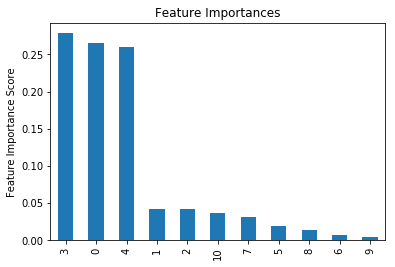

In [93]:
param_test = {'min_samples_split':range(2, 20, 2), 'min_samples_leaf':range(1,10,1), 'learning_rate': (0.05, 0.2, 0.05)}
gv_search = GridSearchCV(estimator = GradientBoostingClassifier(n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10,), 
param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gv_search.fit(X_train_prepared.toarray(), y_train)
gv_search.grid_scores_, gv_search.best_params_, gv_search.best_score_
modelfit(gv_search.best_estimator_, X_train_prepared, y_train)

In [75]:
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
def modelfit(alg, X, Y, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
#     alg.fit(X, Y)
        
    #Predict training set:
    dtrain_predictions = alg.predict(X.toarray())
    dtrain_predprob = alg.predict_proba(X.toarray())[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, X.toarray(), Y, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(Y.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(Y, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

In [103]:
from scipy.stats import randint as sp_randint
param_dist = {
    'min_samples_split':sp_randint(2, 50),
    'min_samples_leaf':sp_randint(1, 50),
    'max_depth': sp_randint(2, 20),
    'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'subsample': [0.7, 0.75, 0.8, 0.85, 0.90],
    'max_features': sp_randint(1, 10),
}

from sklearn.model_selection import RandomizedSearchCV
clf = GradientBoostingClassifier(n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10)
gv_search = RandomizedSearchCV(clf, param_distributions=param_dist,
    n_iter=400, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gv_search.fit(X_train_prepared.toarray(), y_train)
gv_search.grid_scores_, gv_search.best_params_, gv_search.best_score_
# modelfit(gv_search.best_estimator_, X_train_prepared, y_train)

/usr/local/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.87127, std: 0.02605, params: {u'learning_rate': 0.15, u'min_samples_leaf': 31, u'subsample': 0.85, u'min_samples_split': 23, u'max_features': 6, u'max_depth': 15},
  mean: 0.86897, std: 0.02567, params: {u'learning_rate': 0.15, u'min_samples_leaf': 21, u'subsample': 0.8, u'min_samples_split': 48, u'max_features': 9, u'max_depth': 9},
  mean: 0.86747, std: 0.02839, params: {u'learning_rate': 0.15, u'min_samples_leaf': 28, u'subsample': 0.7, u'min_samples_split': 28, u'max_features': 9, u'max_depth': 7},
  mean: 0.86346, std: 0.02980, params: {u'learning_rate': 0.15, u'min_samples_leaf': 12, u'subsample': 0.8, u'min_samples_split': 15, u'max_features': 5, u'max_depth': 16},
  mean: 0.86473, std: 0.02877, params: {u'learning_rate': 0.2, u'min_samples_leaf': 38, u'subsample': 0.8, u'min_samples_split': 23, u'max_features': 2, u'max_depth': 15},
  mean: 0.84838, std: 0.02270, params: {u'learning_rate': 0.05, u'min_samples_leaf': 37, u'subsample': 0.7, u'min_samples_split': 14, u'm

In [105]:
result = gv_search.best_estimator_.predict(X_test_prepared.toarray())
print_result(passage_list, result)

892,0
893,0
894,0
895,0
896,0
897,0
898,0
899,0
900,1
901,0
902,0
903,0
904,1
905,0
906,1
907,1
908,0
909,0
910,1
911,0
912,0
913,0
914,1
915,1
916,1
917,0
918,1
919,0
920,0
921,0
922,0
923,0
924,0
925,0
926,0
927,0
928,1
929,0
930,0
931,0
932,0
933,1
934,0
935,1
936,1
937,0
938,0
939,0
940,1
941,0
942,0
943,0
944,1
945,1
946,0
947,0
948,0
949,0
950,0
951,1
952,0
953,0
954,0
955,1
956,1
957,1
958,1
959,0
960,0
961,1
962,1
963,0
964,0
965,0
966,1
967,1
968,0
969,1
970,0
971,1
972,1
973,0
974,0
975,0
976,0
977,0
978,1
979,1
980,1
981,1
982,0
983,0
984,1
985,0
986,0
987,0
988,1
989,0
990,1
991,0
992,1
993,0
994,0
995,0
996,1
997,0
998,0
999,0
1000,0
1001,0
1002,0
1003,1
1004,1
1005,1
1006,1
1007,0
1008,0
1009,1
1010,1
1011,1
1012,1
1013,0
1014,1
1015,0
1016,0
1017,1
1018,0
1019,1
1020,0
1021,0
1022,0
1023,0
1024,1
1025,0
1026,0
1027,0
1028,0
1029,0
1030,1
1031,0
1032,0
1033,1
1034,0
1035,0
1036,0
1037,0
1038,0
1039,0
1040,1
1041,0
1042,1
1043,0
1044,0
1045,0
1046,0
1047,0
1048,1
1049,1
10